In [ ]:
from google.colab import files
uploaded = files.upload()


Saving bjp_tweets.csv to bjp_tweets.csv


In [ ]:
import pandas as pd

df = pd.read_csv(next(iter(uploaded.keys())))
df.head()


,Unnamed: 0,tweet,target
0,0,ndtv anchor let go over to aap live press conf...,0
1,1,sambit patra attacks rahul gandhi over his cow...,0
2,2,crediting the bjp with taking development to s...,1
3,3,ktrbrs do do false allegations on iasassociati...,0
4,4,gujarat assembly yet to get rs cr as gst compe...,1


In [ ]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = re.sub(r'@\w+|\#', '', text)  # remove @mentions and #
    text = re.sub(r'[^A-Za-z\u0900-\u097F ]+', '', text)  # keep English + Hindi chars
    text = text.lower()  # lowercase
    return text

df["clean_text"] = df["tweet"].apply(clean_text)
df[["tweet","clean_text"]].head()


,tweet,clean_text
0,ndtv anchor let go over to aap live press conf...,ndtv anchor let go over to aap live press conf...
1,sambit patra attacks rahul gandhi over his cow...,sambit patra attacks rahul gandhi over his cow...
2,crediting the bjp with taking development to s...,crediting the bjp with taking development to s...
3,ktrbrs do do false allegations on iasassociati...,ktrbrs do do false allegations on iasassociati...
4,gujarat assembly yet to get rs cr as gst compe...,gujarat assembly yet to get rs cr as gst compe...


In [ ]:
df["target"].value_counts()


,count
target,
1,26515
0,22962


In [ ]:
df["sentiment"] = df["target"].map({1: "Positive", 0: "Negative"})
df[["tweet","sentiment"]].head()


,tweet,sentiment
0,ndtv anchor let go over to aap live press conf...,Negative
1,sambit patra attacks rahul gandhi over his cow...,Negative
2,crediting the bjp with taking development to s...,Positive
3,ktrbrs do do false allegations on iasassociati...,Negative
4,gujarat assembly yet to get rs cr as gst compe...,Positive


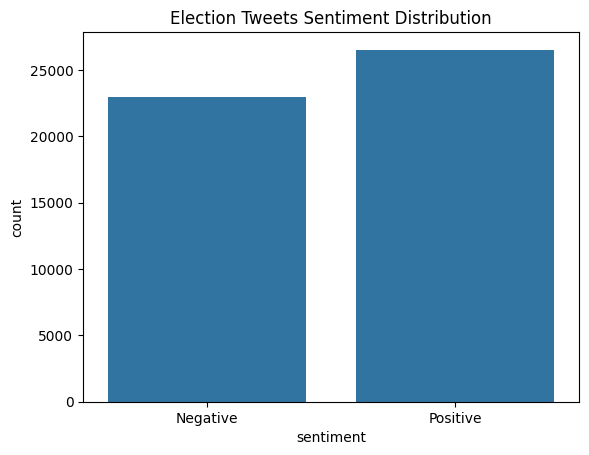

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["sentiment"])
plt.title("Election Tweets Sentiment Distribution")
plt.show()


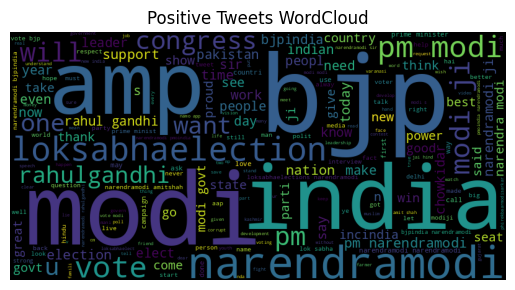

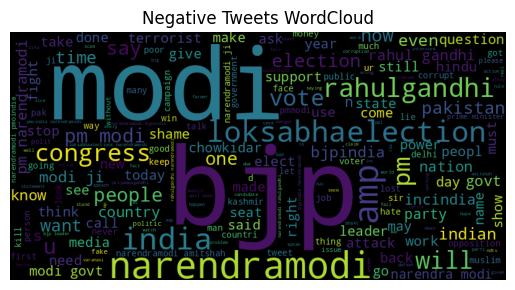

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

positive_text = " ".join(df[df["sentiment"]=="Positive"]["clean_text"])
negative_text = " ".join(df[df["sentiment"]=="Negative"]["clean_text"])

wc_pos = WordCloud(width=800, height=400).generate(positive_text)
wc_neg = WordCloud(width=800, height=400).generate(negative_text)

plt.imshow(wc_pos)
plt.axis("off")
plt.title("Positive Tweets WordCloud")
plt.show()

plt.imshow(wc_neg)
plt.axis("off")
plt.title("Negative Tweets WordCloud")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df["clean_text"].values.astype("U"))
y = df["target"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7801131770412287
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      4560
           1       0.79      0.81      0.80      5336

    accuracy                           0.78      9896
   macro avg       0.78      0.78      0.78      9896
weighted avg       0.78      0.78      0.78      9896



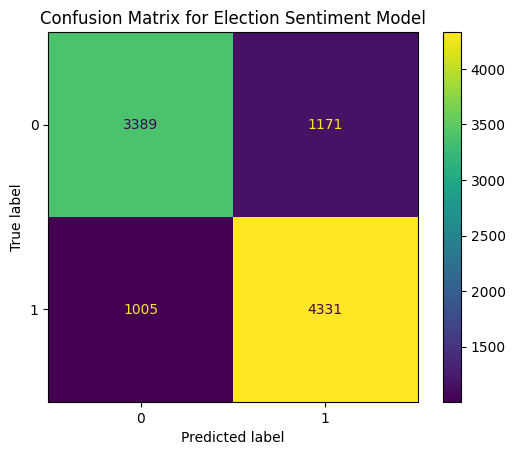

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Election Sentiment Model")
plt.show()


In [ ]:
import joblib

joblib.dump(model, "sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
%%writefile app.py
import streamlit as st
import joblib

model = joblib.load("sentiment_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

st.set_page_config(page_title="Election Sentiment Analyzer")
st.title("🇮🇳 Election Tweet Sentiment Analyzer")

text = st.text_area("Type or paste a tweet here:")

if st.button("Predict Sentiment"):
    clean = text.lower()
    vec = tfidf.transform([clean])
    pred = model.predict(vec)[0]
    if pred == 1:
        st.success("Positive 😀")
    else:
        st.error("Negative 😡")


Writing app.py
